In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Importing the functions that we created
import functions_needed as fn
import scenario_BK as bk

### **Importing the yeild data and cleaning the database** ###

**Zero coupon bond yeild data source:**

SNB: https://data.snb.ch/en/topics/ziredev/cube/rendoblid

BOC: https://www.bankofcanada.ca/rates/interest-rates/bond-yield-curves/

FRED: https://fred.stlouisfed.org/release/tables?eid=212994&rid=354# 


In [3]:
#Loading the excel file
filename = 'data.xlsx'

xls=pd.ExcelFile(filename) 

date_cut = 4174 #end of 2020

df_cad = pd.read_excel(xls, sheet_name='CAD').iloc[0:date_cut,1:]
df_usd = pd.read_excel(xls, sheet_name='USD').iloc[0:date_cut,1:]
df_chf = pd.read_excel(xls, sheet_name='CHF').iloc[0:date_cut,1:]

df_names = [df_cad, df_usd, df_chf]

df = pd.concat(df_names,axis = 1)


In [4]:
#Dropping the nulls
df = df.replace(' na', np.nan)
df = df.replace(' nan', np.nan)
df = df.replace('nan', np.nan)
df = df.replace(' NaN', np.nan)
df = df.replace('.', np.nan)
df = df.replace('', np.nan)

df = df.apply(pd.to_numeric).dropna()

df_og = df

#Canada's yeild is not in percentage terms. Thus, multiplying by 100 to have all currency yeild series at the same level  
df.iloc[:,0: len(df_cad.columns)] = df.iloc[:,0: len(df_cad.columns)]*100


### **Creating the VCV Matrix** ###

In [5]:
df_vcv = pd.DataFrame.cov(df)/(len(df)-1)

#Sample VCV matrix displays the Canadian yeild corrolation between different maturities
df_vcv.iloc[0:10,0:10]

,ZC100YR,ZC200YR,ZC300YR,ZC400YR,ZC500YR,ZC600YR,ZC700YR,ZC800YR,ZC900YR,ZC1000YR
ZC100YR,0.000375,0.000358,0.000340,0.000326,0.000314,0.000302,0.000291,0.000279,0.000267,0.000256
ZC200YR,0.000358,0.000354,0.000344,0.000335,0.000327,0.000319,0.000310,0.000300,0.000290,0.000280
ZC300YR,0.000340,0.000344,0.000342,0.000337,0.000332,0.000326,0.000319,0.000311,0.000303,0.000295
ZC400YR,0.000326,0.000335,0.000337,0.000336,0.000334,0.000330,0.000324,0.000318,0.000311,0.000305
ZC500YR,0.000314,0.000327,0.000332,0.000334,0.000333,0.000331,0.000327,0.000322,0.000317,0.000311
ZC600YR,0.000302,0.000319,0.000326,0.000330,0.000331,0.000330,0.000328,0.000324,0.000320,0.000315
ZC700YR,0.000291,0.000310,0.000319,0.000324,0.000327,0.000328,0.000327,0.000324,0.000321,0.000317
ZC800YR,0.000279,0.000300,0.000311,0.000318,0.000322,0.000324,0.000324,0.000322,0.000320,0.000317
ZC900YR,0.000267,0.000290,0.000303,0.000311,0.000317,0.000320,0.000321,0.000320,0.000318,0.000316
ZC1000YR,0.000256,0.000280,0.000295,0.000305,0.000311,0.000315,0.000317,0.000317,0.000316,0.000315


### **Creating the mean reversion level and mean reversion speed Dataframe for the BK model** ###

In [6]:
#Empty dataframe for the parameters
df_para = pd.DataFrame()
df_bk_san = pd.DataFrame()

#Initial shape of the dataframe to start adding to the dataframe
row, col_length = df_para.shape
row_not_using_this, col_length_bk_san = df_para.shape

#Time step
th = 4
num_scen = 20 #number of scanario

#cunter for the loop
count = 0

#looping through the risk factors
for columnName in df.columns.values: #Make sure to delete the 0:2

   #Calling the parameter from the function
   a,k = fn.paramater_tinator(df[columnName])  

   #calling the corrolation vector for the risk factor from the corr matrix
   corr_vector = fn.std_multi_variate_normal(th, num_scen, df_vcv, columnName)

   #Getting the Diagnol Sigma Value from the subvcv
   #index_rf = np.where(colNames == rf_match)[0] #Getting the index from the 
   sigma = df_vcv[columnName].values[count] #Skipping base case

   #Taking the absolute value because we cant take the log of negative value
   base_case = abs(df[columnName].iloc[len(df)-1])

   #The BK model
   bk_result = bk.bk_model(a,k,sigma,corr_vector, th, base_case)

   #inserting values to the Parameter dataframe
   df_para.insert(col_length, columnName, [a,k], True) 
   row, col_length = df_para.shape

   #Inserting the value for the BK model
   df_bk_san.insert(col_length_bk_san, columnName, bk_result, True) 
   row, col_length_bk_san = df_bk_san.shape

   count += 1

#[a,k]
df_para.index = ['Mean Reversion Speed','Mean Reversion Level']
df_para = df_para.T

#Parameter Dataframe sample showcasing the canadian yeilds
df_para[0:10]

c:\Users\zerocool\Desktop\BK Scenario Model\functions_needed.py:18: RuntimeWarning: invalid value encountered in log
  zt=np.log(rf_df.values[0:n-1])
c:\Users\zerocool\Desktop\BK Scenario Model\functions_needed.py:19: RuntimeWarning: invalid value encountered in log
  xt=np.log(rf_df.values[1:n])
c:\Users\zerocool\Desktop\BK Scenario Model\functions_needed.py:18: RuntimeWarning: divide by zero encountered in log
  zt=np.log(rf_df.values[0:n-1])
c:\Users\zerocool\Desktop\BK Scenario Model\functions_needed.py:19: RuntimeWarning: divide by zero encountered in log
  xt=np.log(rf_df.values[1:n])


,Mean Reversion Speed,Mean Reversion Level
ZC100YR,0.001691,0.634982
ZC200YR,0.001805,0.710212
ZC300YR,0.001782,0.779184
ZC400YR,0.001821,0.843068
ZC500YR,0.001876,0.900742
ZC600YR,0.001912,0.952467
ZC700YR,0.001920,0.998733
ZC800YR,0.001902,1.040607
ZC900YR,0.001870,1.078992
ZC1000YR,0.001832,1.114254


### **Exporting The BK model parameters to excel** ###

In [7]:
#Exporting to excel
# tiabofwnftc.excel_send_tinator('P4BKParameter.xlsx', 'P4BKParameter',df_para)
# tiabofwnftc.excel_send_tinator('P4VCV.xlsx', 'P4VCV',df_vcv)
# tiabofwnftc.excel_send_tinator('bk_san.xlsx', 'BK_SAN',df_bk_san)

### **The BK model output** ###

In [8]:
#Sample
bk_cad_yeild = df_bk_san.iloc[:,:10]
bk_cad_yeild

,ZC100YR,ZC200YR,ZC300YR,ZC400YR,ZC500YR,ZC600YR,ZC700YR,ZC800YR,ZC900YR,ZC1000YR
0,0.170639,0.202617,0.287551,0.353759,0.408338,0.466883,0.535657,0.612344,0.690915,0.765374
1,0.170947,0.202990,0.288009,0.354295,0.408949,0.467565,0.536405,0.613132,0.691751,0.766240
2,0.171257,0.203366,0.288470,0.354833,0.409560,0.468246,0.537149,0.613928,0.692583,0.767106
3,0.171569,0.203745,0.288931,0.355372,0.410172,0.468924,0.537891,0.614718,0.693416,0.767968
4,0.171878,0.204122,0.289393,0.355917,0.410785,0.469606,0.538631,0.615513,0.694249,0.768822
5,0.172187,0.204500,0.289855,0.356454,0.411399,0.470286,0.539368,0.616301,0.695083,0.769692
6,0.172498,0.204877,0.290318,0.356991,0.412009,0.470962,0.540111,0.617096,0.695920,0.770553
7,0.172807,0.205253,0.290782,0.357529,0.412622,0.471645,0.540855,0.617891,0.696747,0.771413
8,0.173117,0.205630,0.291242,0.358071,0.413236,0.472331,0.541598,0.618687,0.697585,0.772283


### **Data Visuals** ###

In [9]:
#Combining the bkmodel scanario to the original cleaned dataframe

total_data = df_og.iloc[:,:10]

total_data = total_data.append(bk_cad_yeild,ignore_index= True)

df.iloc[:,:10]

,ZC100YR,ZC200YR,ZC300YR,ZC400YR,ZC500YR,ZC600YR,ZC700YR,ZC800YR,ZC900YR,ZC1000YR
1,2.686242,3.060668,3.335007,3.567072,3.796404,4.007469,4.175281,4.290598,4.361936,4.407321
2,2.679618,3.048121,3.315848,3.543042,3.770948,3.982991,4.152630,4.269659,4.342303,4.388678
3,2.655845,3.018254,3.290615,3.523583,3.754403,3.967397,4.137811,4.256337,4.331114,4.379687
4,2.730775,3.103664,3.376161,3.606178,3.830689,4.035814,4.198986,4.312033,4.383065,4.428953
5,2.748660,3.115747,3.382176,3.609888,3.834309,4.040038,4.203907,4.317700,4.389619,4.436555
...,...,...,...,...,...,...,...,...,...,...
4165,0.198160,0.231370,0.313830,0.379420,0.434500,0.492960,0.560410,0.634940,0.711260,0.784140
4166,0.183020,0.222670,0.301280,0.362760,0.414750,0.471190,0.537470,0.611330,0.687240,0.759810
4167,0.173990,0.226480,0.307590,0.373030,0.430190,0.491830,0.562540,0.639790,0.718130,0.792290
4171,0.175650,0.207520,0.291660,0.358260,0.413520,0.472370,0.540920,0.617050,0.695000,0.769030


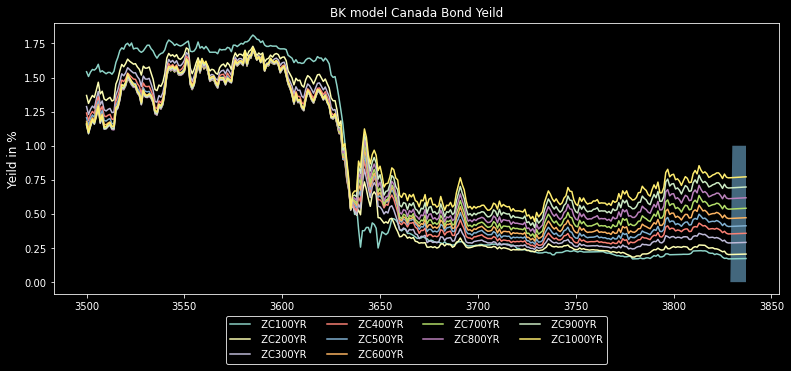

In [10]:
#Note the x axis is not dated becasue we dropped the NA variable. However, this could easily be solved by replacing the NA variable with mean or some other method instead of dropping them
with plt.style.context('dark_background'):
    plt.rcParams['figure.figsize'] = [13, 5]
    plt.plot(total_data.iloc[3500:,:])
    
    plt.fill_between(total_data.iloc[3500:,:].index,
                 total_data.iloc[3500:,:].index > 3829,
                 facecolor = 'lightskyblue',
                 alpha = .5)
 
    #Labling the plot
    plt.title('BK model Canada Bond Yeild')
    plt.ylabel('Yeild in %', fontsize=12)
    plt.legend(total_data, loc='upper center', bbox_to_anchor=(0.5, -0.06),
           fancybox=True, shadow=True, ncol=4)

plt.show()